In [1]:
pip install matplotlib_scalebar

Note: you may need to restart the kernel to use updated packages.


In [2]:
from matplotlib_scalebar.scalebar import ScaleBar


In [22]:
import matplotlib.ticker

from om_decoder.bionano_compare import *

compare = BionanoCompare()

compare.data_prep.num_sizes = 2
compare.data_prep.num_crops_per_size = 1
compare.data_prep.crop_size_range_bp = 40 * 1000, 400 * 1000
compare.data_prep.selector.molecule_ids = [34]
compare.read_cmap()
compare.make_refs()
compare.data_prep.make_crops()
compare.run_spaligner()


selected: 0it [00:00, ?it/s]

crop_sizes [400000.  40000.]


crops: 0it [00:00, ?it/s]

qry items:   0%|          | 0/4 [00:00<?, ?it/s]

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/ynogin/out/LocalizerModule/LocalizerModule-20220904-therapeutic-finch/checkpoint.pickle 




alignments:   0%|          | 0/96 [00:00<?, ?it/s]

len(self.spaligner_items)=2


In [23]:
bionano_image = compare.data_prep.selector.selected[0].bionano_image
bionano_image.read_jxr_image()


In [31]:
scalebar_scale = 130e-9

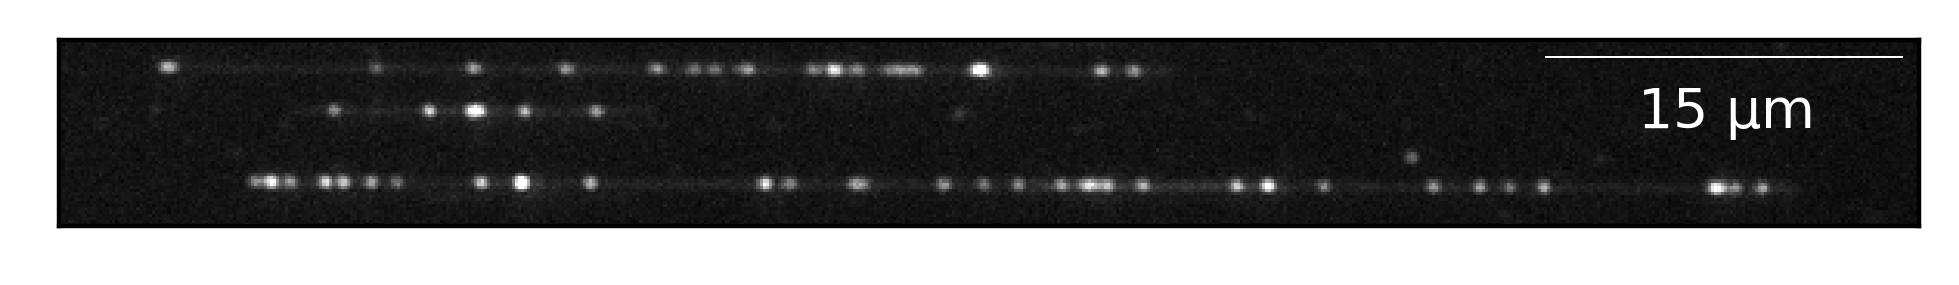

In [32]:
pyplot.figure(dpi=400)
im = bionano_image.fov_image.astype(float)
im = im[1200: 1800, 510: 570]
im = rescale_intensity(im, (0, 1000))
pyplot.imshow(im.T, cmap="gray")

ax = pyplot.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

pyplot.gca().add_artist(ScaleBar(scalebar_scale, color="w", box_alpha=0))

In [66]:
item.crop_item.parent_bnx_item.locs

array([  6124.,  12355.,  28324.,  35973.,  38110.,  46448.,  51647.,
        54127.,  67132.,  72937.,  75344.,  91624.,  99298., 101669.,
       109860., 116106., 118558., 120010., 123804., 128661., 130686.,
       139248., 143280., 148088., 156570., 161266., 175353., 183571.,
       190483., 194623., 198261., 200354., 203287., 210079., 214299.,
       216172., 220354., 222935., 227232., 232993., 242355., 246089.,
       250519., 255059., 260765., 270349., 272573., 273735., 281881.,
       288343., 289642., 292020., 293573., 298511., 301664., 304932.,
       308683., 313849., 317068., 326194., 327909., 330065., 331153.,
       334578., 340041., 345988., 348281., 354242., 362224., 377424.,
       383307., 391628., 402888., 411003., 415711., 417621., 420354.,
       424809., 430559., 433934., 454134., 461251., 468669., 475411.,
       480357., 483855., 488047., 495442., 504942., 510713., 520029.,
       529457.])

(132000.0, 163000.0)

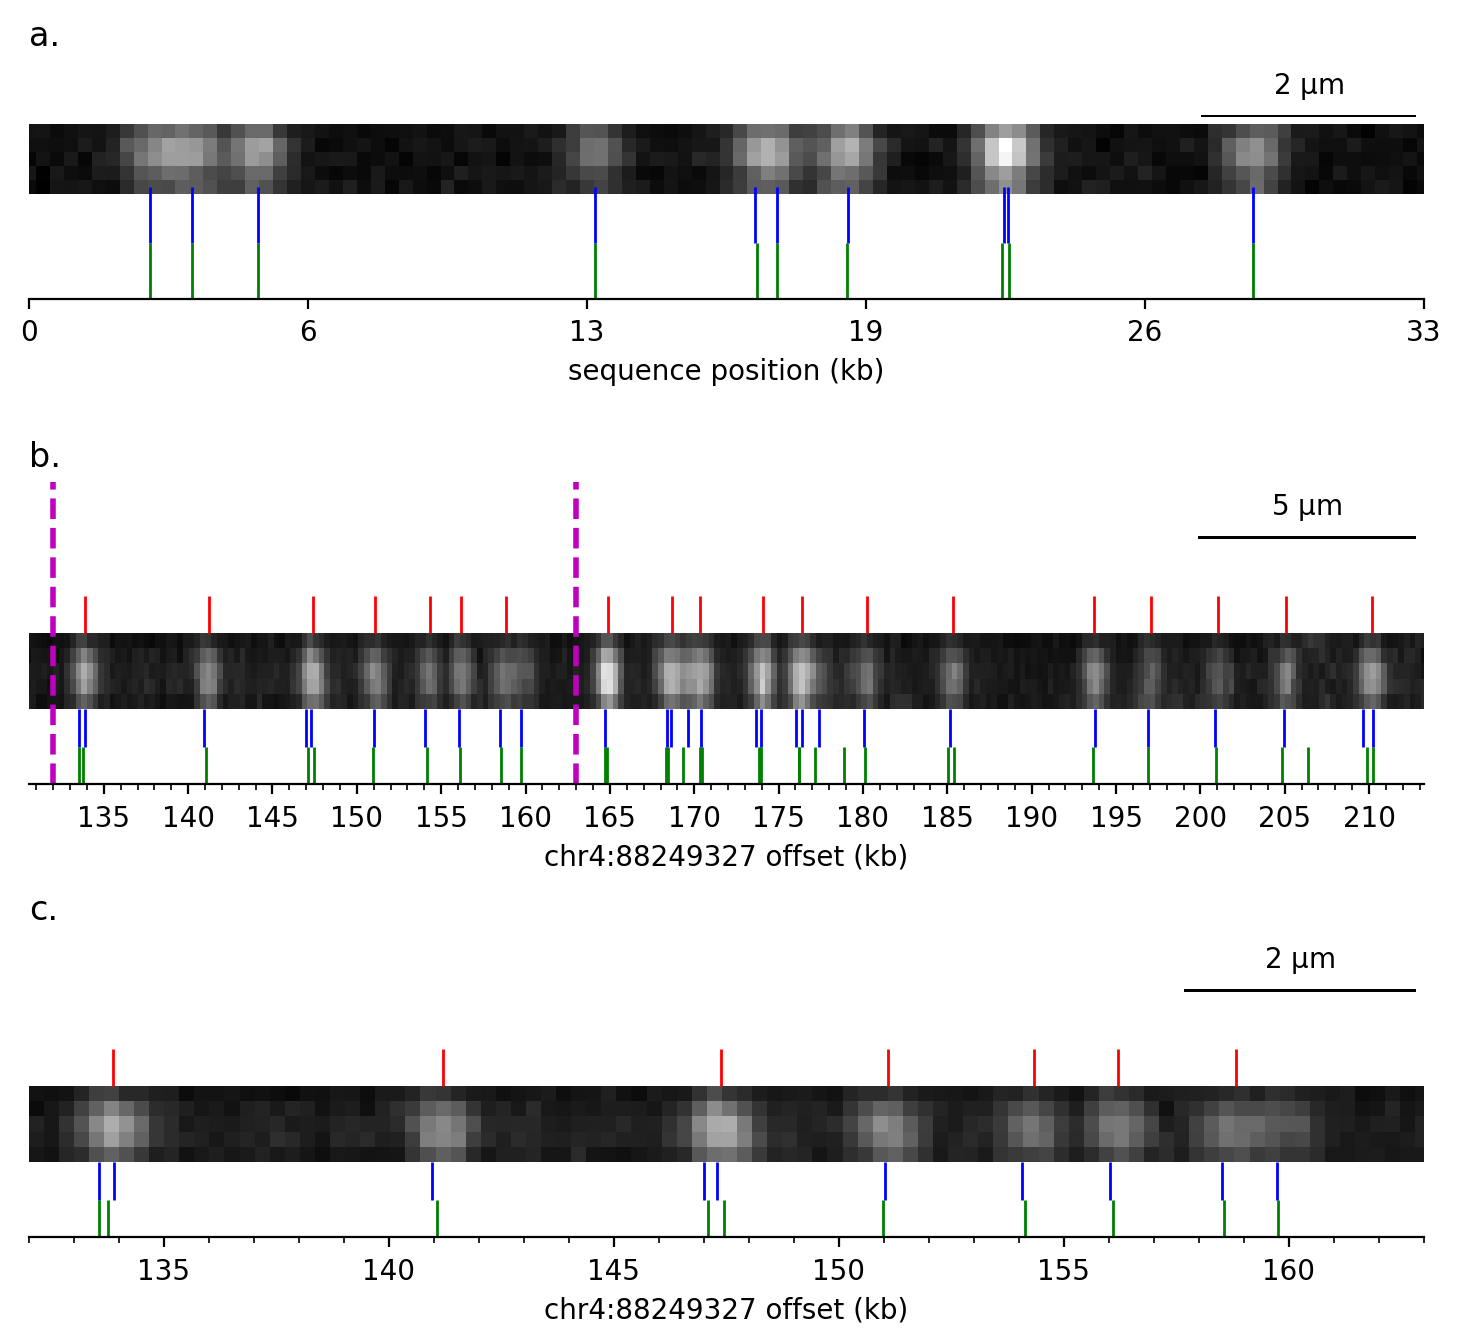

In [76]:

from matplotlib.ticker import MultipleLocator

compare.localizer_module.rng = default_rng(seed=6)
compare.localizer_module.genome_data.sparsity = 3500

data_item = compare.localizer_module.make_data()
inference_item = compare.localizer_module.inference_item(data_item.image)

item = compare.spaligner_items[0]
_, axs = pyplot.subplots(figsize=(9, 8), dpi=200, nrows=3, gridspec_kw=dict(height_ratios=[1,1,1], hspace=.5))

titles = [
    "a.",
    "b.",
    "c.",
    "d.",
]

def _set_formatter(fmt):
    pyplot.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))

def _set_only_x_visible():
    ax = pyplot.gca()    
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


for ax, title in zip(axs, titles):
    ax.set_title(title, loc="left")

def _plot_simulated():
    _set_only_x_visible()

    image = data_item.image[0]
    labeled_pos = data_item.labeled_coords.T[1]

    pyplot.imshow(image, cmap="gray")
    pyplot.eventplot([inference_item.loc_pred, labeled_pos], lineoffsets=[-6, -2], colors=["g", "b"], linewidths=1, linelengths=4)
    
    _set_formatter(lambda x, _: int((x * data_item.scale) / 1000))
    pyplot.gca().invert_yaxis()
    pyplot.ylim(-8, 9)
    
    pyplot.gca().add_artist(ScaleBar(scalebar_scale, color="k", box_alpha=0, scale_loc="top"))

    pyplot.xlabel("sequence position (kb)")

pyplot.sca(axs[0])

_plot_simulated()
pyplot.xlim(0, 100)

def _plot_molecule():
    margin = 3e3

    rvec = compare.refs[item.ref_id]
    qvec = item.qry_item.qry

    lims = max(0, item.alignment_ref[ilims[0]] - margin), min(rvec.max(), item.alignment_ref[ilims[1]] + margin)
    rvec_show = rvec[slice(*rvec.searchsorted(lims))]
    offset = item.alignment_ref[ilims[0]] - item.alignment_qry[ilims[0]]
    mol_offset = lims[0] - offset
    scale = item.qry_item.scale

    im_displ = item.qry_item.inference_item.image_input
    im_displ = rescale_intensity(im_displ)


    pyplot.gca().pcolorfast(
        (0, im_displ.shape[-1] * scale),
                            (1, 2),
                            im_displ, cmap='gray'
    )

    # pyplot.plot(
    #     numpy.stack([
    #         item.alignment_ref - offset,
    #         item.alignment_qry,
    #     ]),
    #     numpy.stack([[.5, 1.0]] * len(item.alignment_ref)).T,
    #     c="b",
    #     lw=2,
    #     ms=1,
    #     marker=".", ls=":", alpha=1.0
    # );
    pyplot.eventplot(item.crop_item.pixel_locs * scale, lineoffsets=[2.25], colors=["r"], linewidths=1, linelengths=.5)
    pyplot.eventplot([rvec_show - offset, item.alignment_qry], lineoffsets=[0, .75], colors=["g", "b"], linelengths=[1, .5], linewidths=1)
    
    pyplot.xlim(lims[0] - offset, lims[1] - offset)
    pyplot.ylim(0, 4)
    _set_only_x_visible()
    _set_formatter(lambda x, _: int(x / 1000))
    ax = pyplot.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5000))
    ax.xaxis.set_minor_locator(MultipleLocator(1000))
    

    pyplot.gca().add_artist(ScaleBar(scalebar_scale / scale, color="k", box_alpha=0, scale_loc="top"))
    pyplot.xlabel(f"chr{item.ref_id}:{int(offset)} offset (kb)")
    # pyplot.grid(visible=True, which="both", axis="x")
    

pyplot.sca(axs[1])

ilims = 26, 53
_plot_molecule()
zoom_lims = 132 * 1000, 163 * 1000
for z in zoom_lims:
    pyplot.axvline(z, ls="--", c="m", lw=2)
pyplot.sca(axs[2])
_plot_molecule()

pyplot.xlim(*zoom_lims)

# pyplot.tight_layout()

# figure_file_base = 
# pyplot.savefig(figure_file_base)

In [69]:
offset

NameError: name 'offset' is not defined

In [ ]:

class FigureMoleculeImages:
    def make_figure_data(self):
        pass

    def make_figure(self):
        pass
